# GeoTIFF files post-processing: Spatial operations

### This noteook illustrates a few steps to obtain the desired spatial subset using `climate4R` and `rgdal`


--------
NOTE: type `?functionname` to display the help page of a function

Load the libraries first:

In [ ]:
#R libraries--------------------------------
library(loadeR)
library(loadeR.2nc)
library(transformeR)
library(geoprocessoR)
library(visualizeR)
library(RColorBrewer)
library(sp)
library(rgdal)

Read the ***.tif** file with `rgdal`. Here we use the CMIP5 Mean temperature Change (deg C) for RCP 8.5.

In [2]:
# read the tif
map <- readGDAL("CMIP5 - Mean temperature (T) Change (deg C) - Long Term (2081-2100) RCP 8.5 AR5 (1986-2005) - Annual.tif")

CMIP5 - Mean temperature (T) Change (deg C) - Long Term (2081-2100) RCP 8.5 AR5 (1986-2005) - Annual.tiff has GDAL driver GTiff 
and has 90 rows and 180 columns


We will continue with climate4R. First we need to convert `map` to an `climate4R` grid object

In [3]:
# convert to a climate4R object
delta <- sgdf2clim(map)

NOTE: One single grid passed to the function: nothing to bind, so the original grid was returned



Use function `spatialPlot` to creat map figures:

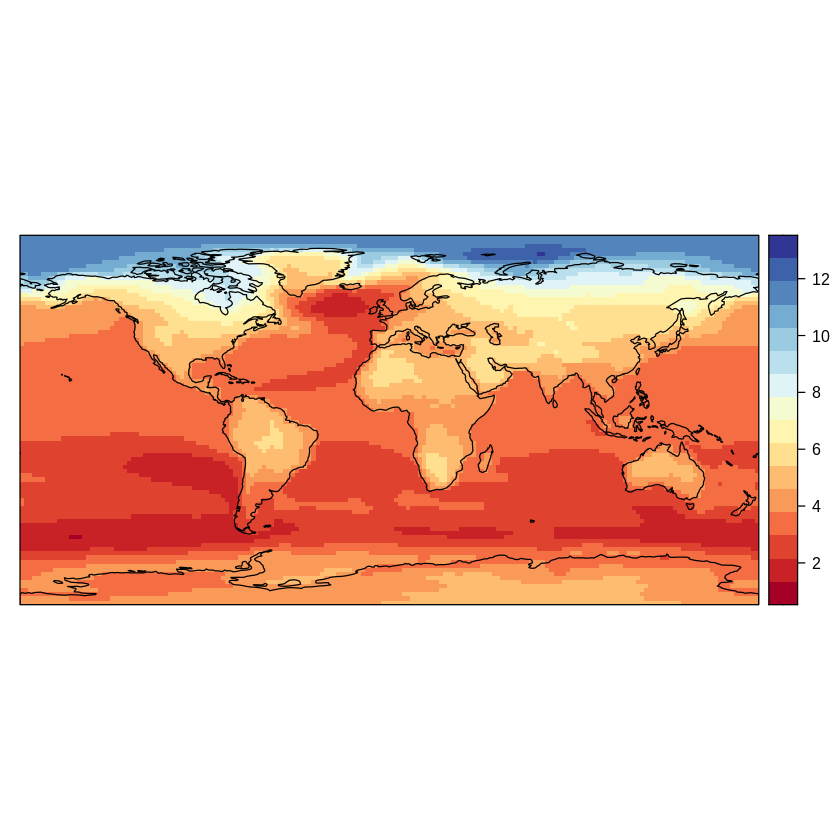

In [4]:
spatialPlot(delta, backdrop.theme = "coastline")

The masking surface for this example is provided as a NetCDF in the ATLAS GitHub repository: https://github.com/SantanderMetGroup/ATLAS/tree/master/reference-grids. Therefore we can load the mask using function `loadGridData`.

In [5]:
# Apply mask
mask <- loadGridData("land_sea_mask_2degree.nc4", var = "sftlf")


[2020-09-22 17:03:03] Defining geo-location parameters

[2020-09-22 17:03:03] Defining time selection parameters

NOTE: Undefined Dataset Time Axis (static variable)

[2020-09-22 17:03:03] Retrieving data subset ...

[2020-09-22 17:03:03] Done



Transform the mask data to a binary grid using function `binaryGrid`:

In [6]:
mask <- binaryGrid(mask, condition = "GT", threshold = 0.999, values = c(NA, 1))

Apply the mask using function `gridArithmetic`, i.e. perfom `delata` x `mask`.

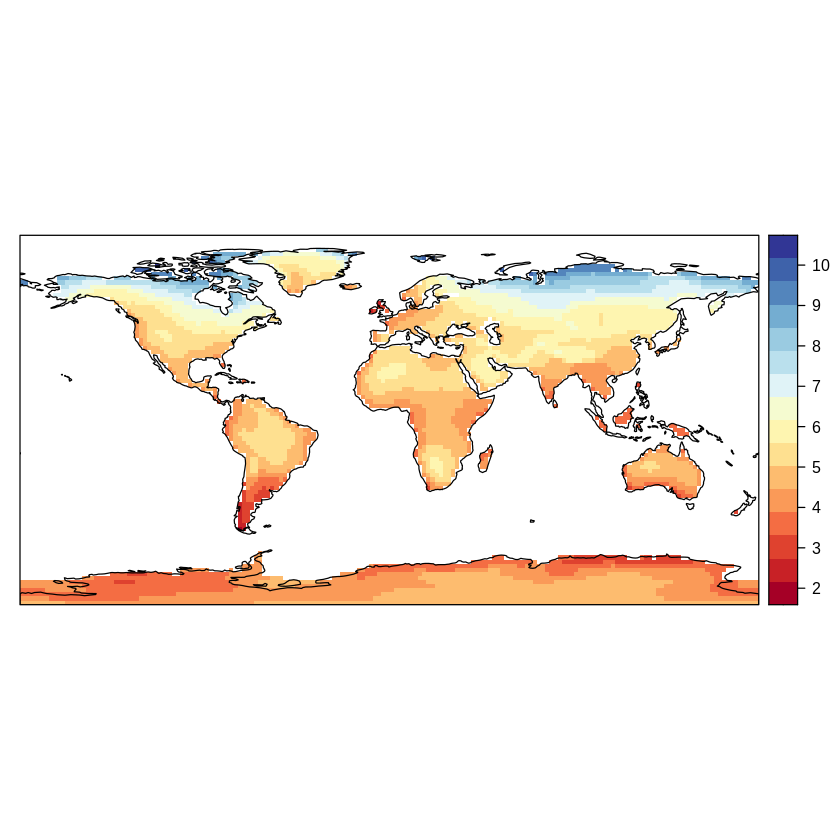

In [7]:
delta.masked <- gridArithmetics(delta, mask, operator = "*")
spatialPlot(delta.masked, backdrop.theme = "coastline")

Get a spatial subset with `subsetGrid`:

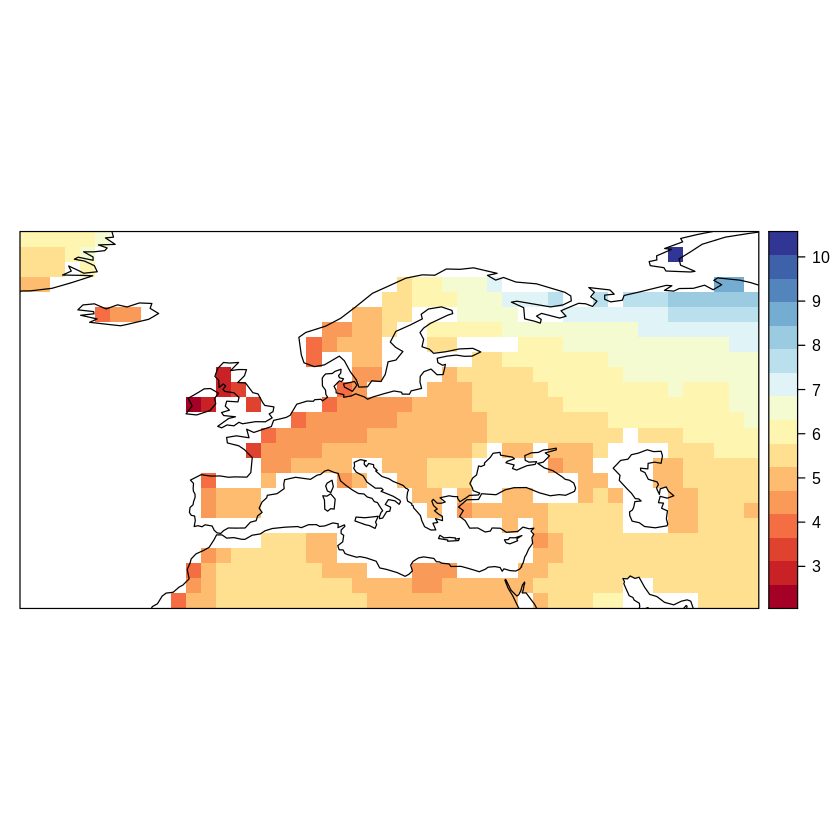

In [8]:
# Subset to Europe
delta.EU <- subsetGrid(delta.masked, lonLim = c(-30, 65), latLim = c(28, 75))
spatialPlot(delta.EU, backdrop.theme = "coastline")

Load the v4 of the IPCC WGI reference regions (available at https://github.com/SantanderMetGroup/ATLAS/tree/master/reference-regions)

In [9]:
# load reference regions and define the default projection
regions <- get(load("IPCC-WGI-reference-regions-v4_R.rda"))
regions <- as(regions, "SpatialPolygons")
proj4string(regions) <- CRS("+init=epsg:4326")

Warning message in proj4string(obj):
“CRS object has comment, which is lost in output”
Warning message in `proj4string<-`(`*tmp*`, value = new("CRS", projargs = "+proj=longlat +datum=WGS84 +no_defs")):
“A new CRS was assigned to an object with an existing CRS:
+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0
without reprojecting.
For reprojection, use function spTransform”


Define the original projection of the data (in this case is the same as the regions)

In [10]:
delta.masked <- projectGrid(delta.masked, proj4string(regions))

Warning message in proj4string(regions):
“CRS object has comment, which is lost in output”
Warning message in projectGrid(delta.masked, proj4string(regions)):
“CAUTION! Grid with previusly defined projection: +proj=longlat +datum=WGS84 +no_defs”
[2020-09-22 17:03:04] Arguments of the original projection defined as +proj=longlat +datum=WGS84 +no_defs



Select the desired regions by acronym. Display the names typing `names(regions)`. Here we select the European regions:

In [11]:
regionnames <- c("NEU", "WCE", "EEU", "MED")

Get a Spatial subset by intersection with a polygons object

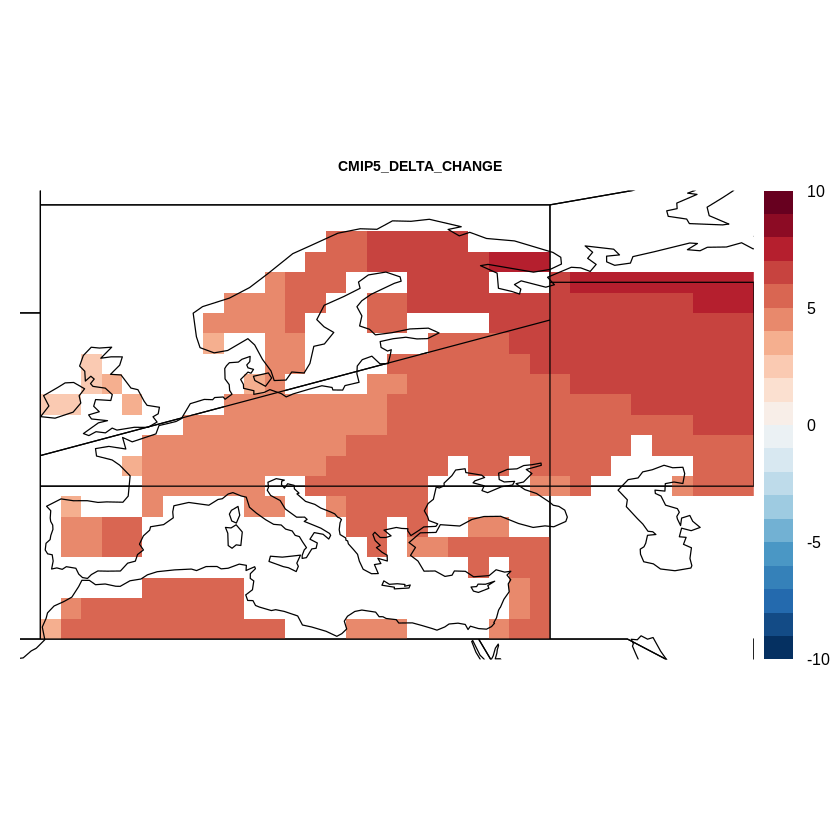

In [12]:
# Overly with reference regions
delta.masked.regs <- overGrid(delta.masked, regions[regionnames], subset = TRUE)

spatialPlot(delta.masked.regs,
            color.theme = "RdBu", 
            rev.colors = TRUE,
            strip = FALSE,
            as.table = TRUE,
            backdrop.theme = "coastline",
            sp.layout = list(list(regions, first = FALSE)),
            par.settings = list(axis.line = list(col = "transparent")),
            main =  list("CMIP5_DELTA_CHANGE",
                         cex = 0.7),
            at = seq(-10, 10, 1),
            set.max = 10,
            set.min = -10)

Calulate regional averages for each region using `aggregateGrid`

In [13]:
reg.averages <- sapply(regionnames, function(i){
      reg <- overGrid(delta.masked, regions[i])
      grid <- aggregateGrid(reg, aggr.lat = list(FUN = "mean", na.rm = TRUE), weight.by.lat = TRUE, aggr.lon = list(FUN = "mean", na.rm = TRUE))
      grid$Data
})
reg.averages

Calculating areal weights...

[2020-09-22 17:03:06] - Aggregating lat dimension...

[2020-09-22 17:03:06] - Done.

[2020-09-22 17:03:06] - Aggregating lon dimension...

[2020-09-22 17:03:06] - Done.

Calculating areal weights...

[2020-09-22 17:03:06] - Aggregating lat dimension...

[2020-09-22 17:03:06] - Done.

[2020-09-22 17:03:06] - Aggregating lon dimension...

[2020-09-22 17:03:06] - Done.

Calculating areal weights...

[2020-09-22 17:03:06] - Aggregating lat dimension...

[2020-09-22 17:03:06] - Done.

[2020-09-22 17:03:06] - Aggregating lon dimension...

[2020-09-22 17:03:06] - Done.

Calculating areal weights...

[2020-09-22 17:03:06] - Aggregating lat dimension...

[2020-09-22 17:03:06] - Done.

[2020-09-22 17:03:06] - Aggregating lon dimension...

[2020-09-22 17:03:06] - Done.



NEU      WCE      EEU      MED 
5.103498 4.888211 6.154353 4.992486